# Generating Recurrent Model

# To-Do:

1. Orientation pinwheel set-up
2. visualize orientation preferences in the uniform-grid
3. fix the weighted sum pool-response in the denominator (Not working when stimulus time extends)
4. play around with different parameters (T_off, stimulus position, etc.)
4. play around with different parameters (in the normalization formula)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from NrnResponse import *
from NSclasses import *
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def CircularRFwt(target, neurons):
    #target: input neuron to generate weights w.r.t others
    #neurons: the list of all other neurons in the same pool as the target
    N = len(neurons)
    r = min(target.grid.xylim)/2 #radius = quarter of box side length
    tar_x, tar_y = target.x, target.y
    weight = np.zeros(N)
    #neuron i in the list has weight i
    for i in range(N):
        n_x, n_y = neurons[i].x, neurons[i].y
        dist = np.sqrt((tar_x-n_x)**2+(tar_y-n_y)**2)
        if dist > r:
            weight[i] = 0
        else:
            weight[i] = 1 - dist/r
    
    return weight

def WtResponse(response, weight):
    #returns the sum of weighted responses in the neuron pool
    assert(len(response) == len(weight))
    #response from neuron i is assigned with weight i
    return sum(weight*response)


In [4]:

def GetRes(nodes, neurons, stimu, Grid):
    '''Obtain input response for all neurons'''
    res = np.zeros(nodes**2)
    for i in range(nodes):
        for j in range(nodes):
            res[i+j*nodes] = NrnResponse(neurons[i+j*nodes], stimu, Grid)
    return res

def WeightRes(nodes, neurons, responses):
    '''Obtain weighted-sum response for all neurons
    Extract weights for each neuron: weight
    Compute weighted sum: res'''
    #responses = all responses from input/last step
    
    res = np.zeros(nodes**2)
    for i in range(nodes):
        for j in range(nodes):
            target = neurons[i+j*nodes]
            rest_neurons = np.delete(neurons,i+j*nodes)
            rest_res = np.delete(responses,i+j*nodes)
            weight = CircularRFwt(target, rest_neurons)
            res[i+j*nodes] = WtResponse(rest_res, weight)
    return res

def NormalizeRes(nodes, neurons, responses, z):
    '''Normalization step1:
    Extract single neuron response: i_tar
    Extract pooled neurons weighted responses: i_pool'''
    #responses = all responses from input/last step
    #z = weighted-sum responses for all neurons

    res = np.zeros(nodes**2)
    for i in range(nodes):
        for j in range(nodes):
            i_pool = z[i+j*nodes]
            i_tar = responses[i+j*nodes]
            res[i+j*nodes] = NormalizedR(i_tar, i_pool)
    return res

def NormalizedR(ini, ini_m, gamma = 1, sigma = 0, exp = 1):
    '''Normalization step2:
    Normalize single neuron's response'''
    #ini = target neuron's response
    #ini_m = other neurons' responses (weighted sum)
    nom = ini**exp
    denom = sigma**exp + ini_m**exp + nom
    return gamma* (nom/denom)

def ToMatrix(nodes,arr):
    '''Reshape an array of responses into matrix'''
    res = np.zeros((nodes,nodes))
    for i in range(nodes):
        for j in range(nodes):
            res[i,j] = arr[i+j*nodes]
    return res

In [6]:
def initialization(nodes):
    assert(nodes >= 4)
    
    Grid = Mygrid(1, 1, 50, 50)
    #Xgrid and Ygrid within [-1, 1]x[-1, 1] 
    Xspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    Yspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)

    
    neurons = [0]*(nodes**2)
    for i in range(nodes):
        for j in range(nodes):
            x = Xspace[i]
            y = Yspace[j]
            neurons[i+j*nodes] = MyNrn(x, y, 
                                             (i+j*nodes)*np.pi/(nodes**2), Grid)
        
    return Xspace, Yspace, neurons, Grid

In [7]:
### Iteration in time model ver.1 ###

def TmeModel(number, total, time_off):
    T = total 
    nodes = number
    Sti = MyPtStm(0, 0, np.pi/2) #initial point stimulus
    S_t = []
    T_on = 0; T_off = time_off
    for i in range(T):
        if (i < T_off):
            S_t.append(Sti)
        else:
            S_t.append(0)
    Xspace, Yspace, neurons, Grid = initialization(nodes)
    X = []
    Y = []

    if S_t[0] != 0:
        X.append(GetRes(nodes, neurons, S_t[0], Grid))
        z = WeightRes(nodes, neurons, X[0])
    else:
        z = 0
    Y.append(NormalizeRes(nodes, neurons, X[0], z))
    for i in range(1,T):
        if S_t[i] != 0:
            X.append(GetRes(nodes, neurons, S_t[i], Grid))
            z =  WeightRes(nodes, neurons, X[i])+Y[i-1]
        else:
            z = WeightRes(nodes, neurons, Y[i-1])
        Y.append(NormalizeRes(nodes, neurons, Y[i-1], z))
    return Xspace, Yspace, Y

In [8]:
def MatrixPlot(nodes, Y):
    N = len(Y)
    MatrixY = []
    fig, axes = plt.subplots(int(N/5), 5, figsize = [15,int(N/2)])

    for i in range(N):
        ax = axes[int(i/5),(i%5)]
        MatrixY.append(ToMatrix(nodes,Y[i]))
        ax.axis('off')
        ax.title.set_text('T = {}'.format(i+1))

        #add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.imshow(ToMatrix(nodes,Y[i]), cmap='hot')
        fig.colorbar(im, cax=cax, orientation='vertical')



In [9]:
def DifferencePlot(nodes, Y):
    N = len(Y)
    fig, axes = plt.subplots(int(N/5), 5, figsize = [15,int(N/2)])
    ax = axes[0,0]
    im = ax.imshow(ToMatrix(nodes,Y[0]), cmap='hot')
    ax.axis('off')
    ax.title.set_text('T1')
    #add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    for i in range(1,len(Y)):
        M1 = ToMatrix(nodes,Y[i-1])
        M2 = ToMatrix(nodes,Y[i])

        ax = axes[int(i/5),(i%5)]
        im = ax.imshow(M2-M1, cmap='hot')
        ax.axis('off')
        ax.title.set_text('T{} - T{}'.format(i+1, i))
        
        #add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')



## Animation

<IPython.core.display.Javascript object>


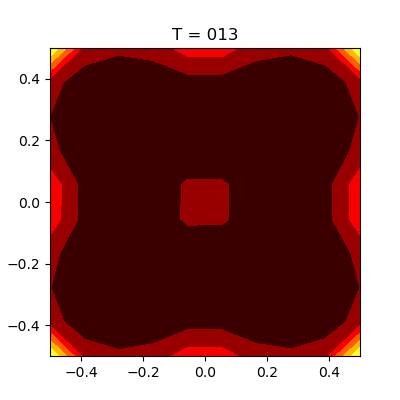

AttributeError: 'FuncAnimation' object has no attribute 'show'

In [10]:
import matplotlib.animation
from matplotlib.animation import FuncAnimation, PillowWriter 
#necessary 
%matplotlib notebook 

def getAnimation(n):
    Xspace, Yspace, Y = TmeModel(n, 20, 1)
    N = len(Y)
    MatrixY = []
    for i in range(N):
        MatrixY.append(ToMatrix(n,Y[i]))

    fig,ax = plt.subplots(figsize = (4,4))

    def animate(i):
        ax.clear()
        ax.contourf(Xspace, Yspace, MatrixY[i], cmap='hot')
        ax.set_title('T = %03d'%(i)) 

    ani =  matplotlib.animation.FuncAnimation(fig,animate,frames=20,interval=200,blit=False)

    #ani.save('test.gif',  writer='imagemagick', fps=10)
    ani.show()
    
getAnimation(10)

## Static plots

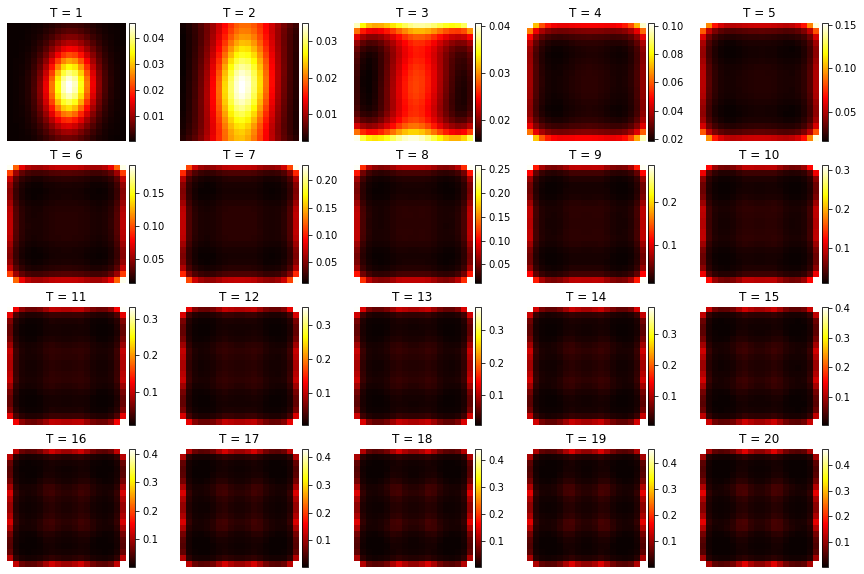

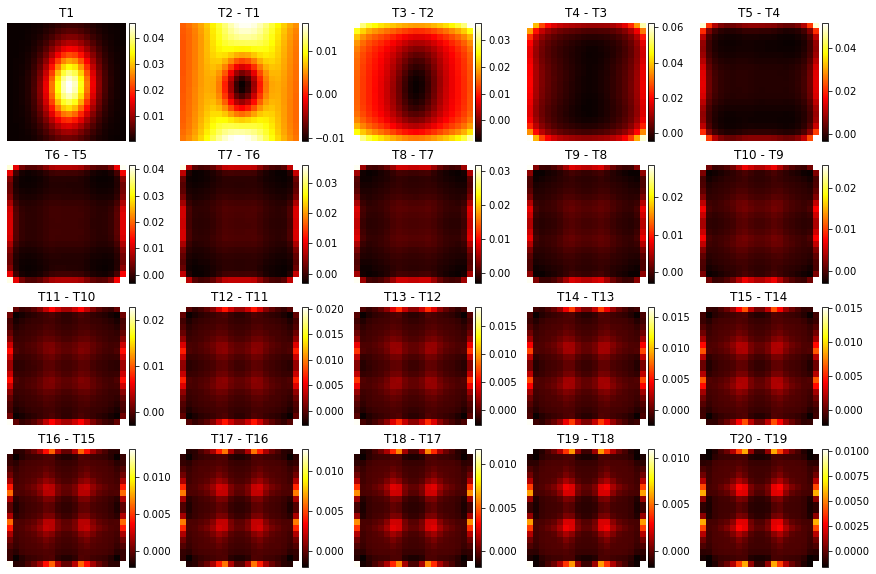

In [49]:
n = 20
Y1 = TmeModel(n, 20, 1)[2]
MatrixPlot(n, Y1)
DifferencePlot(n, Y1)

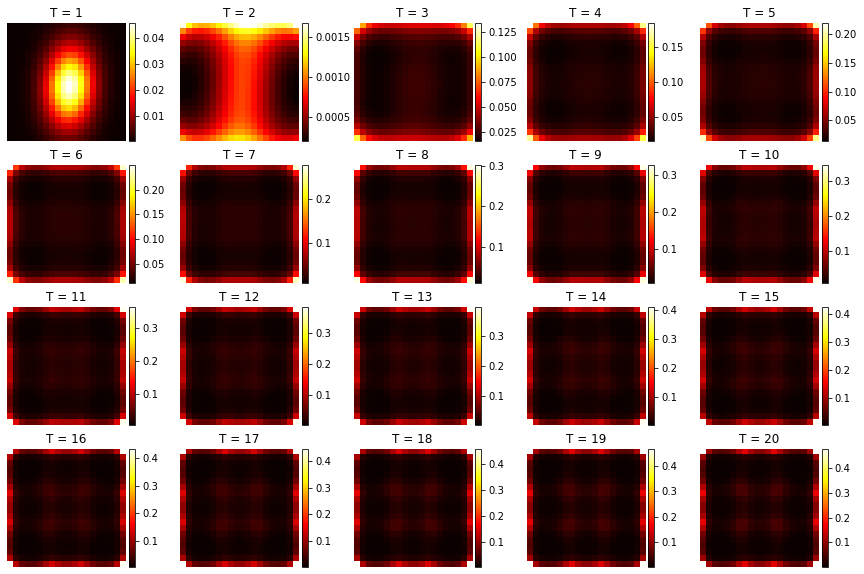

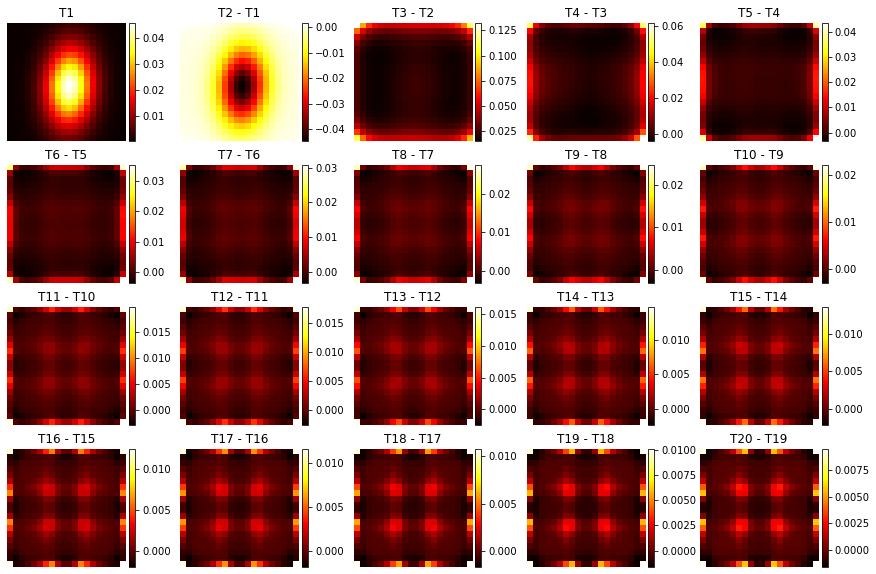

In [50]:
n = 20
Y2 = TmeModel(n, 20, 2)[2]
MatrixPlot(n, Y2)
DifferencePlot(n, Y2)

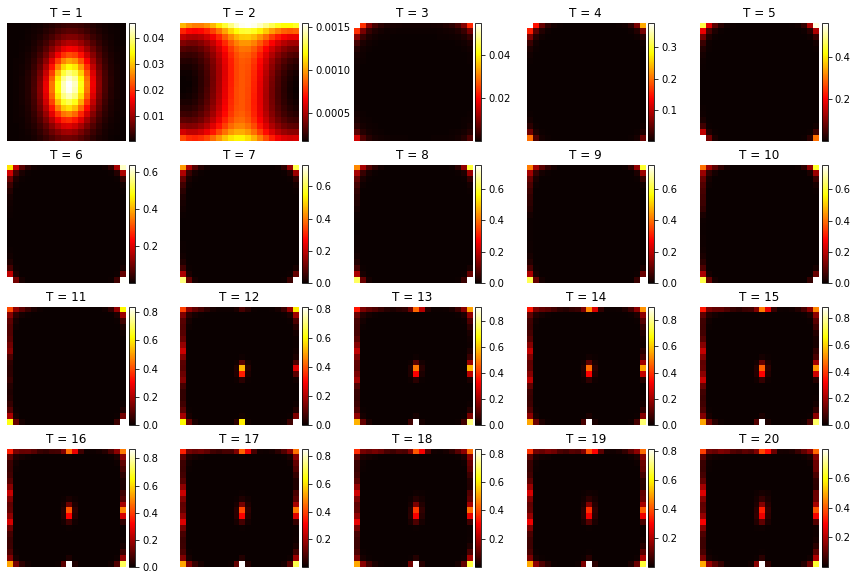

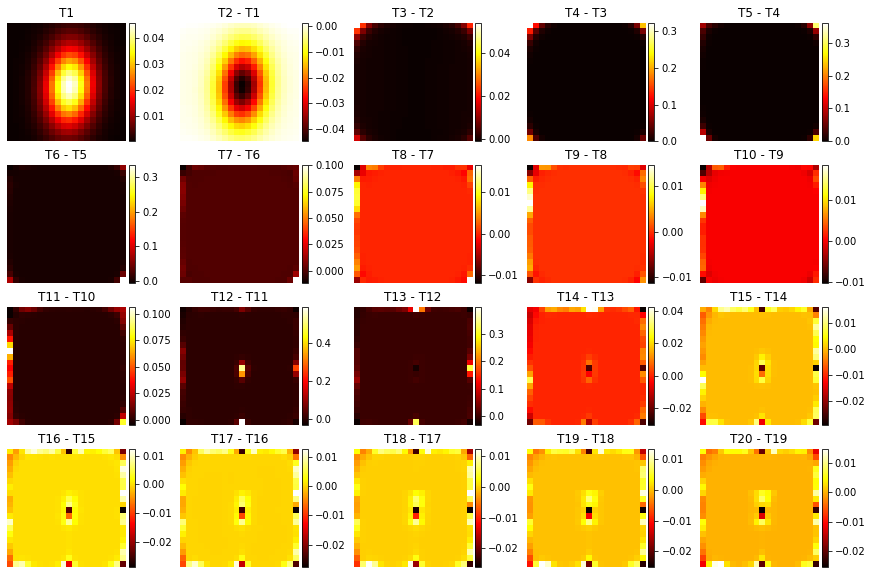

In [39]:
n = 20
Y3 = TmeModel(n, 20, 10)[2]
MatrixPlot(n, Y3)
DifferencePlot(n, Y3)